# THE NIRB TWO-GRID METHOD

Script by Elise Grosjean (elise.grosjean@ensta-paris.fr)

In [70]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-fem

Let us consider a parameterized problem.
The NIRB two-grid method follows the same ideas as in the Snapshot Proper Orthogonal Decomposition (POD) algorithm and is decomposed in two parts: 
- The "offline part" : First we compute a reduced basis (denoted $\Phi_i$) from several snapshots of the solution (for different parameter values in a parameter set $\mathcal{G}$),
- The "online part" : then we project onto it the solution that we are looking for, with a new parameter value $\mu \in \mathcal{G}$. What differs from the Snapshot POD is the projection step. Instead of solving the projection of the model onto the reduced basis (known as the reduced problem), we are going to use a coarse solution (let's named it $u_H$) with the parameter value $\mu$. Since we employ a coarse mesh instead of a fine one, this step is much faster than the execusion of a usual high fidelity solver launched on a fine mesh. Our new approximation will then be given by:
$$ u_{new}=\underset{i=1}{\overset{N}{\sum}} (u_H(\mu), \Phi_i)\Phi_i(x),$$
where $(\cdot,\cdot)$ is the $L^2$ inner product.

In [1]:
# import packages
import skfem  # for Finite Element Method
import numpy as np
import matplotlib.pyplot as plt

## 1) The 2D-driven cavity problem:
#
We are going to use in this example the famous 2D-driven cavity problem with the Finite Element Method (FEM), which consists in 
solving on a unit square (denoted $\Omega$) the following equations:
\begin{align}
&-\nu \Delta u + (u \cdot \nabla) u + \nabla p =0, \textrm{ in } \Omega,\\
& \nabla. u=0, \textrm{ in } \Omega,\\
& (u_1,u_2)=(1,0), \textrm{ on } \Omega_{up}:=\partial \Omega \cap \{y=1\},\\
& (u_1,u_2)=(0,0), \textrm{ on } \partial \Omega \backslash \Omega_{up},
\end{align}
where $u=(u_1,u_2) \in V:=H^1_{d,0}(\Omega)^2=\{u \in H^1(\Omega)^2, \gamma_{\partial \Omega \backslash \Omega_{up}} u=0, \ \gamma_{up} u =(1,0) \}$ ($\gamma$ stands for the trace operator) represents the velocity of the incompressible fluid, $ p \in L^2(\Omega)$ its pressure, and $\nu=\frac{1}{Re}$ where $Re$ is the Reynolds parameter. Here, the Reynolds number is our parameter of interest ($\mu=Re$).
For the nonlinearity we adopt a fixed-point iteration scheme, and after multiplying by test functions $q$ and $v$ (resp. for pressure and velocity), which in variational form reads:
\begin{equation}
\nu (\nabla u^k, \nabla v) + ((u^{k-1} \cdot \nabla) u^k,v) -  (p^k, \nabla \cdot v) - (q, \nabla \cdot u^k) + 10^{-10} (p^k, q) =0, \textrm{in } \Omega,
\end{equation}
where $u^{k-1}$ is the previous step solution, and we iterate until a threshold is reached (until $\|u^{k}-u^{k-1}\| < \varepsilon $).
Here, with the term $ 10^{-10} (p^k, q)  $, we impose the average of the pressure $\int_{\Omega} p^k $ to be equal to $0$. For more details on how we derive this formulation, visit the link : https://github.com/grosjean1/navierStokes (FEM.pdf).

We employ Taylor-Hood elements to get a proper solution (e.g. P2-P1 for the tuple velocity-pressure) and obtain the system $\mathbf{K} \mathbf{x} =\mathbf{f}$ to solve where $\mathbf{K}= \begin{pmatrix}
\mathbf{A} & -\mathbf{B}^T\\
-\mathbf{B} & 10^{-10} \mathbf{C}
\end{pmatrix}$, $\mathbf{x}$ stands for the tuple velocity-pressure $(u_1^k,u_2^k,p^k)$, and where the assembled matrix $\mathbf{A}$ corresponds to the bilinear part $ \nu (\nabla u^k, \nabla v) + ((u^{k-1} \cdot \nabla) u^k),v) $, the matrix $ B$ to the bilinear part $(  p^k ,\nabla \cdot v)$ and $\mathbf{C}$ is the mass matrix applied to the pressure variable ($(\cdot,\cdot)$ represents either the $L^2$ inner-product onto the velocity space or onto the pressure space). 


The dirichlet boundary conditions are imposed with a penalization method, called with scikit-FEM by the line: 

solve(*condense(K,f, x=uvp, D=D)),

where x=uvp gives the values at the boundaries of the velocity and D refers to the boundary decomposition.



<skfem MeshTri1 object>
  Number of elements: 2048
  Number of vertices: 1089
  Number of nodes: 1089
  Named boundaries [# facets]: left [32], bottom [32], right [32], top [32], down [32], up [32]


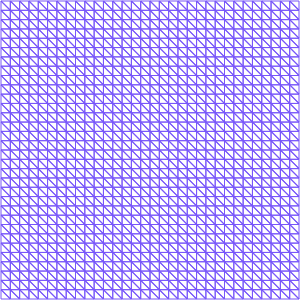

In [2]:
# First we define a mesh for the unit square
mesh= skfem.MeshTri().refined(5).with_boundaries(                                                                
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)

print(mesh)
mesh


In [3]:
"""First step."""

# Assembling matrices

from skfem.assembly import BilinearForm, LinearForm
from skfem.helpers import grad, dot,div,ddot

@BilinearForm
def laplace(u, v, _):
    print("gradula",np.shape(grad(u)))
    return dot(grad(u), grad(v))

@BilinearForm
def vector_laplace(u, v, w):
    # same as laplace but for u,v vectors 
    return w.nu*ddot(grad(u), grad(v))

@BilinearForm
def mass(u, v, _):
    return u * v

@BilinearForm
def divu(u, v, w):
    return div(u) * v
divergence = divu
 
    #z=w.up*u.grad[0] + w.up * u.grad[1] #(u^(k-1). grad u^k). v
@BilinearForm
def nonlinearterm(u, v, w):
    up_x, up_y = w.up 
    v_x,v_y=v[0],v[1]
    
    gradu=grad(u)
    gradxu_x=gradu[0,0] 
    gradxu_y=gradu[0,1]
    gradyu_x=gradu[1,0]
    gradyu_y=gradu[1,1]
    
    return (up_x*gradxu_x+up_y*gradxu_y)*v_x + (up_x*gradyu_x+up_y*gradyu_y)*v_y
  

In the 2D-driven cavity problem, the parameter of interest is the Reynolds number. In the code bellow, the function SolveCavityProblem(Re,Mesh) takes as parameters the Reynolds number and a mesh, and returns the associated solution (velocity-pressure).

In [4]:
""" Finally we solve the problem """
from skfem import *
# Compute solution of the 2d-driven cavity problem
element = {'u': ElementVector(ElementTriP2()),
           'p': ElementTriP1()} #[u,v,p]= velocity-pressure with Taylor-Hood P2-P1 FEM elements


def SolveCavityProblem(Re,Mesh):
    # Re is the reynolds parameter #
    Nu=1./Re 
    print('Parameter nu:',Nu)

    basis = {variable: Basis(Mesh, e, intorder=4)
         for variable, e in element.items()} # FEM space
    up=basis['u'].zeros() #initialization for non-linear term previous solution
    
    B =divu.assemble( basis['u'], basis['p']) # B.T=p*div(v) and B=q *div(u) with q=pressure test function
    C = mass.assemble(basis['p'],basis['p'] ) # 1^-10 * p*q impose pressure average equal to 0.
    A1 =vector_laplace.assemble(basis['u'],nu=Nu) # nu* grad(u) * grad(v) with u=[u1,u2] and v is test function v=[v1,v2]
    #A2=nonlinearterm.assemble(basis['u'],up=basis['u'].interpolate(up)) #(u^(k-1). grad u^k). v


    # global matrix Stokes
    K = bmat([[A1, -B.T],
          [-B, 1e-10 * C]], 'csr')

    def profil_up(x):
        """return u=(0,1) at the up boundary and (0,0) otherwise """
        return np.stack([x[1]==1, np.zeros_like(x[0])])
    
    up_basis = FacetBasis(Mesh, element['u'], facets=Mesh.boundaries['up'])
    all_basis = FacetBasis(Mesh, element['u'])

    uvp_boundary = np.hstack((
        all_basis.project(profil_up), # can be replaced by all_basis.project(profil_up), will be 0 by default for the other boundaries
        basis['p'].zeros(),
    ))

    D = basis['u'].get_dofs(['up', 'down', 'right','left']) # since we put D on basis['u'], there will be no penalization on pressure
    f = np.concatenate([basis['u'].zeros(),basis['p'].zeros()]) # =0

    #######################
    ### SOLVING PROBLEM ###
    #######################
    uvp = solve(*condense(K,f, x=uvp_boundary, D=D))
    velocity, pressure = np.split(uvp, K.blocks)

    for i in range(15): #fixed-point iterations
        up=velocity.copy() # updating velocity
        A2=nonlinearterm.assemble(basis['u'],up=basis['u'].interpolate(up))

     
        # global matrix assembling update
        K = bmat([[A1+A2, -B.T],
          [-B, 1e-10 * C]], 'csr')

        uvp = solve(*condense(K,f, x=uvp_boundary, D=D))
     
        velocity, pressure = np.split(uvp, K.blocks)

    return velocity,pressure
    


Parameter nu: 0.006666666666666667


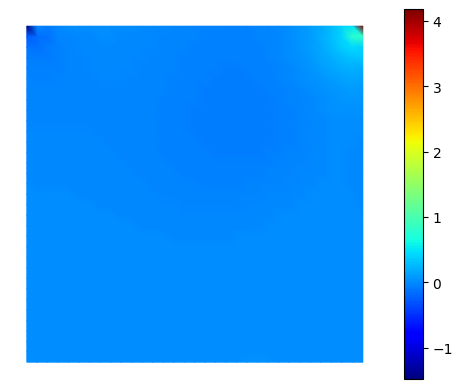

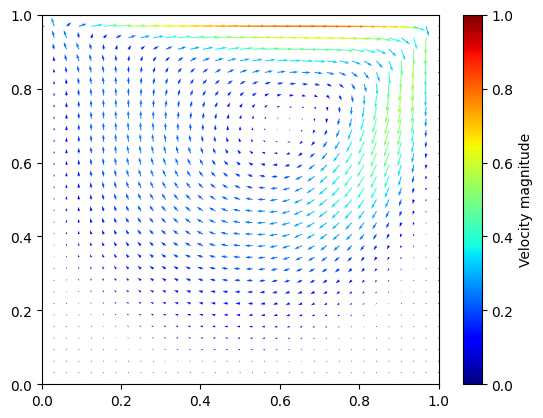

In [5]:
""" We may visualize the solutions """

from skfem.visuals.matplotlib import plot, draw, savefig

velocity,pressure=SolveCavityProblem(150,mesh) 

def visualize_pressure(Mesh,Pressure):
    ## Function that allows us to visualize the pressure
    #from skfem.visuals.matplotlib import plot
    return plot(Mesh, Pressure, shading='gouraud', colorbar=True)
    
visualize_pressure(mesh,pressure).show()

def visualize_velocity(Mesh,Velocity):
    ## Function that allows us to visualize the velocity
    fig, ax = plt.subplots()

    # Calculate the magnitude of velocity
    basis = {variable: Basis(Mesh, e, intorder=4)
            for variable, e in element.items()} # FEM space
    velocity1 = Velocity[basis['u'].nodal_dofs].copy()
    magnitude = np.sqrt(velocity1[0]**2 + velocity1[1]**2)

    # Display the velocity fields with colors for magnitude
    quiver = ax.quiver(*mesh.p, *velocity1, magnitude, angles='xy', cmap='jet')

    # colorbar
    cbar = plt.colorbar(quiver, ax=ax)

    # Limits of axis for the mesh
    ax.set_xlim([Mesh.p[0].min(), Mesh.p[0].max()])
    ax.set_ylim([Mesh.p[1].min(), Mesh.p[1].max()])
    cbar.set_label('Velocity magnitude')
    # show results
    plt.show()

visualize_velocity(mesh,velocity)

### NIRB two-grid method

We are now able to proceed with the offline and online parts of the NIRB two-grid method.
We will apply the NIRB method on the velocity but it works the same for the pressure.


#### OFFLINE PART


We define the two meshes: one with a fine size (which will be used to generate the reduced basis) and one with a coarser size (used during the online step to enhance the run-times).

In [6]:
## FINE MESH
FineMesh = skfem.MeshTri().refined(5).with_boundaries(                                                                
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)
FineBasis = {variable: Basis(FineMesh, e, intorder=4)
            for variable, e in element.items()} # FEM space

NumberOfNodesFineMesh = FineMesh.p.shape[1]
print("number of fine nodes: ",NumberOfNodesFineMesh)
#num_dofs_uFineMesh = basis['u'].doflocs.shape[1] # or np.shape(velocity)[0] for DOFs

## COARSER MESH
CoarseMesh= skfem.MeshTri().refined(3).with_boundaries(                                                                
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,        
        }                                                                                                                               
)
CoarseBasis = {variable: Basis(CoarseMesh, e, intorder=4)
            for variable, e in element.items()} # FEM space

NumberOfNodesCoarseMesh = CoarseMesh.p.shape[1]
print("number of coarse nodes: ",NumberOfNodesCoarseMesh )


number of nodes:  1089
number of nodes:  81


Now we may proceed with the POD algorithm (but any other method that constructs an adequate basis for the solution manifold could be used, e.g. such as a greedy approach). We decompose the snapshots by one average over the parameters and by one fluctuation part. Then, the POD modes are estimated with the fluctuations.

In [11]:
""" POD (can be replaced by a greedy approach) """
""" POD """

print("-----------------------------------")
print("        Offline                    ")
print("-----------------------------------")

NumberOfSnapshots=10 #Training set
NumberOfModes=6 #tol

print("number of modes: ",NumberOfModes)

#####  Create fluctuation parts for the snapshots #####
Re=1. #first Reynolds number
AveragedSnapshots=FineBasis["u"].zeros()

FineSnapshots=[]
for i in range(NumberOfSnapshots):
    velocity,pressure=SolveCavityProblem(Re,FineMesh)
    print(Re)
    #visualize_velocity(mesh,velocity)
    AveragedSnapshots+=velocity
    FineSnapshots.append(velocity)
    
    Re+=45

print("last Reynolds:",Re)
AveragedSnapshots/=NumberOfSnapshots

for i in range(NumberOfSnapshots):
    FineSnapshots[i]-=AveragedSnapshots
    #visualize_velocity(FineMesh,FineSnapshots[i])

## SVD ##
@BilinearForm
def massVelocity(u, v, _):
    return u[0] * v[0]+u[1] * v[1]
    
L2=massVelocity.assemble(FineBasis["u"])
# We first compute the correlation matrix C_ij = (u_i,u_j)
CorrelationMatrix = np.zeros((NumberOfSnapshots, NumberOfSnapshots))
for i, snapshot1 in enumerate(FineSnapshots):
    MatVecProduct = L2.dot(snapshot1)
    for j, snapshot2 in enumerate(FineSnapshots):
        if i >= j:
            CorrelationMatrix[i, j] = np.dot(MatVecProduct, snapshot2)
            CorrelationMatrix[j, i] = CorrelationMatrix[i, j]

#print("CorrelationMatrix",CorrelationMatrix)
# Then, we compute the eigenvalues/eigenvectors of C 
EigenValues, EigenVectors = np.linalg.eigh(CorrelationMatrix, UPLO="L") #SVD: C eigenVectors=eigenValues eigenVectors
idx = EigenValues.argsort()[::-1] # sort the eigenvalues

TotEigenValues = EigenValues[idx]
TotEigenVectors = EigenVectors[:, idx]
EigenValues=TotEigenValues[0:NumberOfModes]
EigenVectors=TotEigenVectors[:,0:NumberOfModes]

print("eigenvalues: ",EigenValues)

RIC=1-np.sum(EigenValues)/np.sum(TotEigenValues) #must be close to 0
print("Relativ Information Content (must be close to 0):",RIC)
RIClist=[]
for i in range(len(EigenValues)):
    RIClist.append(1-np.sum(EigenValues[:i])/np.sum(TotEigenValues)) #must be close to 0


ChangeOfBasisMatrix = np.zeros((NumberOfModes,NumberOfSnapshots))

for j in range(NumberOfModes):
    ChangeOfBasisMatrix[j,:] = EigenVectors[:,j]/np.sqrt(EigenValues[j])

ReducedBasis = np.dot(ChangeOfBasisMatrix,FineSnapshots)


#visualize_velocity(mesh,ReducedBasis[2])

# orthogonality test
#for i in range(NumberOfModes):
#    MatVecProduct = L2.dot(ReducedBasis[i])
#    for j in range(NumberOfModes):    
#        test = np.dot(MatVecProduct, ReducedBasis[j])
#        print("orthogonal:",test)

-----------------------------------
        Offline                    
-----------------------------------
number of modes:  6
Parameter nu: 1.0
1.0
Parameter nu: 0.021739130434782608
46.0
Parameter nu: 0.01098901098901099
91.0
Parameter nu: 0.007352941176470588
136.0
Parameter nu: 0.0055248618784530384
181.0
Parameter nu: 0.004424778761061947
226.0
Parameter nu: 0.0036900369003690036
271.0
Parameter nu: 0.0031645569620253164
316.0
Parameter nu: 0.002770083102493075
361.0
Parameter nu: 0.0024630541871921183
406.0
last Reynolds: 451.0
eigenvalues:  [2.54755393e-02 3.20763587e-03 2.74529238e-04 2.30847869e-05
 2.67682655e-06 1.94549831e-07]
Relativ Information Content (must be close to 0): 2.7825776416356973e-07


A greedy algorithm is a procedure which aims at approximating each element of a compact set (here the manifold $S_h=Span\{u_h^0, \dots,u_h^n, \}$) in a Hilbert space $V_h$ by a subspace of properly selected elements of this compact set. The greedy procedure is a fast way to compute the modes by choosing some suitable parameters with respect to a criterion. At each Greedy iteration, the new RB parameter is chosen such that the corresponding snapshot is the worse approached by the previous basis space. In general, this strategy does not produce an optimal solution but yields to more accurate approximation with the rectification post-treatment.
We have seen that the projection of a solution onto the reduced basis is given by $P^n(u)=\underset{i=1}{\overset{n}{\sum}} (u,\Phi_i)\Phi_i$.

- During the greedy algorithm, we first set $\Phi_0:=\frac{u_h^0}{\|u_h^0\|}$ (or any snapshots in the training set).

- Then, we look for another snapshot $u_h^k$ in the training set that maximizes the error  between itself and its projection onto the reduced basis, built from the first snapshot: $\frac{\|u_h^k - P^0(u_h^k) \|}{\|u_h^k\|}$, and we set $\Phi_1= \frac{u_h^k - P^0(u_h^k)}{\|u_h^k - P^0(u_h^k)\|}$.

- We iterate until obtaining a tolerance threshold on this error maximization.


  

In [15]:
""" Greedy approach  """ #(instead of POD)
print("-----------------------------------")
print(" STEP1: Offline                    ")
print("-----------------------------------")
NumberOfSnapshots=10
NumberOfModes=6
#tol=1e-6

print("number of modes: ",NumberOfModes)

#####  Create fluctuation parts for the snapshots #####
Re=1. #first Reynolds number
AveragedSnapshots=FineBasis["u"].zeros()

FineSnapshots=[]
for i in range(NumberOfSnapshots):
    velocity,pressure=SolveCavityProblem(Re,FineMesh)
    print(Re)
    #visualize_velocity(mesh,velocity)
    AveragedSnapshots+=velocity
    FineSnapshots.append(velocity)
    
    Re+=45

print("last Reynolds:",Re)
AveragedSnapshots/=NumberOfSnapshots

for i in range(NumberOfSnapshots):
    FineSnapshots[i]-=AveragedSnapshots
    #visualize_velocity(FineMesh,FineSnapshots[i])

## SVD ##
@BilinearForm
def massVelocity(u, v, _):
    return u[0] * v[0]+u[1] * v[1]
    
L2=massVelocity.assemble(FineBasis["u"])
# We first compute the correlation matrix C_ij = (u_i,u_j)

ReducedBasis=np.zeros((NumberOfModes,np.shape(velocity)[0]))
SnapshotNorm=np.sqrt(np.dot(FineSnapshots[0],L2.dot(FineSnapshots[0])))

ReducedBasis[0,:]=FineSnapshots[0]/SnapshotNorm #first mode
ListReducedOrderBasis=[ReducedBasis[0,:]]
ListeIndex=[0] #first snapshot 
    
MatrixBasisProduct=[L2.dot(ListReducedOrderBasis[0])]
    
for n in range(1,NumberOfModes):
    
    TestVector=dict() # dictionnary: vector in the reduced basis if maxTest if maximum
    
    for j in range(NumberOfSnapshots): 
        if not (j in ListeIndex): #if index not yet in the basis 
        
            #w= u_j - sum_k (u_j,Phi_k) Phi_k
            w=FineSnapshots[j]-sum((bk*np.dot(MatrixBasisProduct[k],FineSnapshots[j]) for k,bk in enumerate(ListReducedOrderBasis)))#,axis=0)#potential vector to add in the reduced basis
                
            
            NormL2W=np.sqrt(np.dot((L2.dot(w)),w))
            if np.sqrt(np.dot(FineSnapshots[j],L2.dot(FineSnapshots[j]))) > 1e-10:
                GreedyMaximumTest=NormL2W/np.sqrt(np.dot(FineSnapshots[j],L2.dot(FineSnapshots[j]))) #we seek the max
            else:
                GreedyMaximumTest=NormL2W #we seek the max
            
            TestVector[j]=[GreedyMaximumTest,w,NormL2W]
      
    Index=max(TestVector, key = lambda k: TestVector[k][0]) #index of the snapshot used
    ListeIndex.append(Index) #adding the corresponding j in the list
    
    ListReducedOrderBasis.append(TestVector[Index][1]/TestVector[Index][2])#orthonormalization in L2
    MatrixBasisProduct.append(L2.dot(ListReducedOrderBasis[n]))
        
    ReducedBasis[n,:]=ListReducedOrderBasis[-1] 

#print(np.dot(L2.dot(ReducedBasis[0,:]),ReducedBasis[1,:]))


-----------------------------------
 STEP1: Offline                    
-----------------------------------
number of modes:  6
Parameter nu: 1.0
1.0
Parameter nu: 0.021739130434782608
46.0
Parameter nu: 0.01098901098901099
91.0
Parameter nu: 0.007352941176470588
136.0
Parameter nu: 0.0055248618784530384
181.0
Parameter nu: 0.004424778761061947
226.0
Parameter nu: 0.0036900369003690036
271.0
Parameter nu: 0.0031645569620253164
316.0
Parameter nu: 0.002770083102493075
361.0
Parameter nu: 0.0024630541871921183
406.0
last Reynolds: 451.0


Now that we have our reduced basis, we complete the offline part with the rectification post-treatment (see details in the NIRB 2-grid section):

In [16]:
print("-----------------------------------")
print("---- RECTIFICATION POST-TREATMENT -")
print("-----------------------------------")
# We need several coarse snapshots
# Compute solution of the 2d-driven cavity problem on a coarser mesh

Re=1.
AveragedCoarseSnapshots=CoarseBasis["u"].zeros()
CoarseSnapshots=[]
Re=1. #first Reynolds number

for i in range(NumberOfSnapshots):
    velocity,pressure=SolveCavityProblem(Re,CoarseMesh)
    print(Re)
    #visualize_velocity(mesh,velocity)
    AveragedCoarseSnapshots+=velocity
    CoarseSnapshots.append(velocity)
    
    Re+=45
print("last Reynolds:",Re)
AveragedCoarseSnapshots/=NumberOfSnapshots

for i in range(NumberOfSnapshots):
    CoarseSnapshots[i]-=AveragedCoarseSnapshots


## Interpolation of coarse solutions on the fine mesh to do the inner product with the reduced basis
from scipy.spatial import cKDTree
InterpolatedCoarseSnapshots=[]
for i in range(NumberOfSnapshots):
    snapshotH =CoarseSnapshots[i]
    # Nearest interpolation
    
    # Use of cKDTree to interpolate to the nearest neighbor
    tree = cKDTree(CoarseBasis['u'].doflocs.T)  # Find the nodes of the degree of freedom of the coarse solution 
    distances, indices = tree.query(FineBasis['u'].doflocs.T)  # Find the nearest nodes on the fine grid
 
    u_interpolated = snapshotH[indices]

    InterpolatedCoarseSnapshots.append(u_interpolated)

    
alpha=np.zeros((NumberOfSnapshots,NumberOfModes)) # Fine coefficients
beta=np.zeros((NumberOfSnapshots,NumberOfModes)) # Coarse coefficients

for i in range(NumberOfSnapshots):
    for j in range(NumberOfModes):
        alpha[i,j]=np.array(FineSnapshots[i])@(L2@ReducedBasis[j,:])
        beta[i,j]=np.array(InterpolatedCoarseSnapshots[i])@(L2@ReducedBasis[j,:])

lambd=1e-12 #Regularization Tikhonov parameter (AT@A +lambda I_d)^-1
R=np.zeros((NumberOfModes,NumberOfModes)) # rectification matrix
for i in range(NumberOfModes):
    R[i,:]=(np.linalg.inv(beta.transpose()@beta+lambd*np.eye(NumberOfModes))@beta.transpose()@alpha[:,i])

#print("rectification matrix ", R)

-----------------------------------
---- RECTIFICATION POST-TREATMENT -
-----------------------------------
Parameter nu: 1.0
1.0
Parameter nu: 0.021739130434782608
46.0
Parameter nu: 0.01098901098901099
91.0
Parameter nu: 0.007352941176470588
136.0
Parameter nu: 0.0055248618784530384
181.0
Parameter nu: 0.004424778761061947
226.0
Parameter nu: 0.0036900369003690036
271.0
Parameter nu: 0.0031645569620253164
316.0
Parameter nu: 0.002770083102493075
361.0
Parameter nu: 0.0024630541871921183
406.0
last Reynolds: 451.0


Now we can check for our reduced basis accuracy.

In [17]:
print("-----------------------------------")
print("  Reduced basis accuracy           ")
print("-----------------------------------")
### Offline Errors
print("Offline Errors")
CompressionErrors=[]
H1compressionErrors=[]

#snap,pressure=SolveCavityProblem(1,FineMesh)
H10=vector_laplace.assemble(FineBasis['u'],nu=1)
for snap in FineSnapshots:
    ExactSolution =snap
   
    CompressedSolutionU= ExactSolution@(L2@ReducedBasis.transpose())
    ReconstructedCompressedSolution = np.dot(CompressedSolutionU, ReducedBasis) #pas de tps 0
    
    norml2ExactSolution=np.sqrt(ExactSolution@(L2@ExactSolution))
    normh1ExactSolution=np.sqrt(ExactSolution@(H10@ExactSolution))
    t=ReconstructedCompressedSolution-ExactSolution
    
    if norml2ExactSolution !=0 and normh1ExactSolution != 0:
        relError=np.sqrt(t@L2@t)/norml2ExactSolution
        relh1Error=np.sqrt(t@H10@t)/normh1ExactSolution
    else:
        relError = np.linalg.norm(ReconstructedCompressedSolution-ExactSolution)
    CompressionErrors.append(relError)
    H1compressionErrors.append(relh1Error)

print("L2 compression error =", CompressionErrors)
print("H1 compression error =", H1compressionErrors)




-----------------------------------
  Reduced basis accuracy           
-----------------------------------
Offline Errors
L2 compression error = [5.491498134937185e-15, 2.538313760278743e-15, 0.005047680588374, 6.856034389920962e-15, 8.453759485141844e-15, 3.9049158686965763e-14, 0.0020752097057184925, 0.0023026771887077963, 0.001300456504031845, 4.306568104312849e-14]
H1 compression error = [8.150120550679852e-15, 3.1926038636758358e-15, 0.007551053558987375, 1.1597328204733784e-14, 1.1403564181195185e-14, 5.922423559212762e-14, 0.0031117393782900357, 0.003318676996131936, 0.00183471957047579, 6.15532382843519e-14]


In [18]:
print("-----------------------------------")
print("     ONLINE PART          !!!      ")
print("-----------------------------------")
### Online Errors
print("Online Errors")

Ret=110 ##Targeted parameter
H10=vector_laplace.assemble(FineBasis['u'],nu=1)

velocity,pressure=SolveCavityProblem(Ret,CoarseMesh) ##Targeted parameter
velocity-=AveragedCoarseSnapshots

## Interpolation of coarse solutions on the fine mesh to do the inner product with the reduced basis
snapshotH =velocity
# Nearest interpolation
# Use of cKDTree to interpolate to the nearest neighbor
tree = cKDTree(CoarseBasis['u'].doflocs.T)  # Find the nodes of the degree of freedom of the coarse solution 
distances, indices = tree.query(FineBasis['u'].doflocs.T)  # Find the nearest nodes on the fine grid
u_interpolated = snapshotH[indices]
InterpolatedCoarseSnapshot=u_interpolated

velocity,pressure=SolveCavityProblem(Ret,FineMesh)
velocity-=AveragedSnapshots
ExactSolution =velocity
   
    
CompressedSolutionU= InterpolatedCoarseSnapshot@(L2@ReducedBasis.transpose())
coef=np.zeros(NumberOfModes)
for i in range(NumberOfModes):
    coef[i]=0
    for j in range(NumberOfModes):
        coef[i]+=R[i,j]*CompressedSolutionU[j]

#RectifiedSolutionU=np.dot(R,CompressedSolutionU)
ReconstructedCompressedSolution = np.dot(coef, ReducedBasis) 
    
norml2ExactSolution=np.sqrt(ExactSolution@(L2@ExactSolution))
normh1ExactSolution=np.sqrt(ExactSolution@(H10@ExactSolution))
t=np.abs(ReconstructedCompressedSolution-ExactSolution)
    
if norml2ExactSolution !=0 and normh1ExactSolution != 0:
    relError=np.sqrt(t@L2@t)/norml2ExactSolution
    relh1Error=np.sqrt(t@H10@t)/normh1ExactSolution
else:

    relError = np.linalg.norm(ReconstructedCompressedSolution-ExactSolution)
    


print("L2 relative compression error =", relError)
print("H1 relative compression error =", relh1Error)


-----------------------------------
     ONLINE PART          !!!      
-----------------------------------
Online Errors
Parameter nu: 0.00909090909090909
Parameter nu: 0.00909090909090909
L2 relative compression error = 0.0036365919269498643
H1 relative compression error = 0.0051482180568242445
